# Final Project

Name: Kartikeya Sharma <br/>Class: CSCI 349 - Intro to Data Mining  
Semester: Spring 2021  
Instructor: Brian King  

### Step 0: Environment Setup

#### Step 0.0: Installations

- **phonenumbers:** Python wrapper for Google's phone numbers API: ```conda install phonenumbers```<br/>
- **us:** package for conveniently working with state abbreviations: ```pip install us``` because conda-forge installation does not work (and is not listed as a primary way of installing this package, so we're stuck with pip)<br/>
- **uszipcode:** package that has a vast amount of information on zipcodes, including the major city, post office city, common city, county, state, **area code list** (helpful), **latitude** (helpful), **longitude** (helpful), timezone, demographics (population, population_density, population by age, population by gender, population by race, etc.)... talk about data mining ```pip install uszipcode``` (pip had a solid installation of this)
- **MUST USE PYTHON 3.6**

#### Step 0.1: Imports

In [1]:
%time
# imports used in the course
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# from  matplotlib.ticker import PercentFormatter
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# from sklearn.utils import shuffle
from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_predict
# from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# from sklearn.preprocessing import StandardScaler
# from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [2]:
# custom imports (not used in the course)
import phonenumbers
import us
from uszipcode import SearchEngine # importing what is needed per the documentation
from functools import lru_cache
import math

```uszipcode``` documentation<sup>5</sup>

In [3]:
%time 
try:
    df_raw = pd.read_csv("../data/Consumer_Complaints_Data_-_Unwanted_Calls_raw.csv")
except:
    # import from online if not available on machine
    df_raw = pd.read_csv('https://query.data.world/s/24xzbr2jaeuohhwmrzhj7jcyrdamlw')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [4]:
# df = df_raw.sample(frac=(0.95/116.4)).copy(deep=True)
df = df_raw

```df``` will be considered the sample of the data set, where ```df_raw``` will be considered as the whole data set; this is for simplicity and convenience by design, so I don't have to write ```df_samp``` or ```df_sample``` every time. 

I am choosing 0.95/116.4 because ~116.4 MB is how much all of the data takes up (whole raw data set) and ~0.95 (MB) - ends up a bit more than that, though - is the amount of space that we want the sample (also before preprocessing) to take, keeping the data being worked with under 1 MB; this is the fraction of data that will be retained for analysis.

<br/>Data provided from fcc.gov<sup>2</sup>

In [ ]:
import pickle
favorite_color = pickle.load( open( "df.p", "rb" ) )

### Step 1: Pre-Processing

#### Step 1.0 Inspect Data at a Macro Level

The purposes of this analysis, None will be np.NaN.

In [5]:
df.fillna(value=np.nan, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174008 entries, 0 to 1174007
Data columns (total 12 columns):
 #   Column                                   Non-Null Count    Dtype 
---  ------                                   --------------    ----- 
 0   Ticket ID                                1174008 non-null  int64 
 1   Date of Issue                            1166745 non-null  object
 2   Time of Issue                            1009691 non-null  object
 3   Form                                     1174008 non-null  object
 4   Method                                   1170312 non-null  object
 5   Issue                                    1174008 non-null  object
 6   Caller ID Number                         1088224 non-null  object
 7   Type of Call or Messge                   1009814 non-null  object
 8   Advertiser Business Number               923817 non-null   object
 9   State                                    1173095 non-null  object
 10  Zip                           

In [7]:
df.head()

,Ticket ID,Date of Issue,Time of Issue,Form,Method,Issue,Caller ID Number,Type of Call or Messge,Advertiser Business Number,State,Zip,Location (Center point of the Zip Code)
0,4242701,09/18/2020,9:27 a.m.,Phone,Wireless (cell phone/other mobile device),Unwanted Calls,863-722-2235,Abandoned Calls,863-722-2235,UT,84104,"UT 84104-2930\n(40.734434, -111.930582)"
1,4242711,09/18/2020,5:02 p.m.,Phone,Wireless (cell phone/other mobile device),Unwanted Calls,435-253-3663,Abandoned Calls,435-253-3663,UT,84104,"UT 84104-2930\n(40.734434, -111.930582)"
2,4242717,09/14/2020,1:09 p.m.,Phone,Wireless (cell phone/other mobile device),Unwanted Calls,727-655-9941,Abandoned Calls,727-655-9941,UT,84104,"UT 84104-2930\n(40.734434, -111.930582)"
3,4242725,09/16/2020,3:40 p.m.,Phone,Wireless (cell phone/other mobile device),Unwanted Calls,385-213-5003,Abandoned Calls,385-213-5003,UT,84104,"UT 84104-2930\n(40.734434, -111.930582)"
4,4242729,09/21/2020,8:02 P.M.,Phone,Wireless (cell phone/other mobile device),Unwanted Calls,None,Text Message,347-387-3011,WA,98110,"WA 98110\n(47.643688, -122.534497)"


#### Step 1.1: Discard, Format, Downsize Each Column

**Column #0 "Ticket ID":** Unless there are some duplicate ticket values that should be looked into further, I intend on discarding them.<sup>2</sup>

In [8]:
df["Ticket ID"].value_counts().sort_values(ascending=False).head(1)

4194304    1
Name: Ticket ID, dtype: int64

Clearly no duplicate values. Discarding Column #0 "Ticket ID."

In [9]:
df.drop(columns="Ticket ID", inplace=True)

<br/>**Column #1 "Date of Issue":** This column represents the date when the user actually experienced the issue. It will be stored as a date without a time zone (since not all observations gave a particular time so that the dates can be informatively localized accordingly).

What % are NaN values? Just to get an idea (ideally not more than a percent or two).

In [10]:
df["Date of Issue"].isna().sum() / len(df.index)

0.006186499580922788

In [11]:
def _convert_datetime(dt):
    try:
        return pd.to_datetime(dt)
    except: 
        return np.NaN

In [12]:
df["Date of Issue"] = df["Date of Issue"].apply(_convert_datetime)

In [13]:
df = df[df["Date of Issue"] >= pd.to_datetime("October 31, 2014")]

Starting point of the data set is October 31, 2014.<sup>2</sup>

In [14]:
df["Date of Issue"].isna().sum() / len(df.index)

0.0

<br/>**Column #2 "Time of Issue":** This column represents the time when the user actually experienced the issue. This information appears to be too specific for our analysis.<sup>2</sup>

What % are NaN values? Just to get an idea (ideally not more than a percent or two).

In [15]:
df["Time of Issue"].isna().sum() / len(df.index)

0.13540461645879118

A lot of non-values and not a *necessary* column (could miss out on analyzing what time of data the calls tend to come in, and by time zone, that is, but there is too much missing data to do this). Dropping it from the DataFrame.

In [16]:
df = df.drop(columns="Time of Issue")

<br/>**Column #3 "Form":** This represents the method through which the consumers were contacted by the reported caller.<sup>2</sup>

In [17]:
df["Form"].value_counts()

Phone    1164399
Name: Form, dtype: int64

These are all "Phone"; we don't need it. (The whole raw data set of the sample that we are analyzing is, in turn, part of a larger data set maintained by the FCC with complaints regarding phone calls, TV service providers, Internet service providers, etc.<sup>8</sup> 

In [18]:
df.drop(columns="Form", inplace=True)

<br/>**Column #4 "Method":** How the reported caller contacted the consumer.<sup>2</sup>

What % are NaN values? Just to get an idea (ideally not more than a percent or two).

In [19]:
df["Method"].isna().sum() / len(df.index)

0.0004869464848389598

In [20]:
df.loc[:,"Method"] = pd.Categorical(df["Method"].copy(deep=True), ordered=False)

In [21]:
df["Method"].head()

0    Wireless (cell phone/other mobile device)
1    Wireless (cell phone/other mobile device)
2    Wireless (cell phone/other mobile device)
3    Wireless (cell phone/other mobile device)
4    Wireless (cell phone/other mobile device)
Name: Method, dtype: category
Categories (3, object): ['Internet (VOIP)', 'Wired', 'Wireless (cell phone/other mobile device)']

There are three possibilities (nominal) categories: Internet (VOIP), which is something like Google Voice, wired, which is a landline, and wireless, which is a cell phone.<sup>2</sup>

It is not necessary to clarify that wireless means cell phone or other mobile device. This category will be renamed to wireless.

In [22]:
df["Method"].cat.rename_categories(
    new_categories = {"Wireless (cell phone/other mobile device)": "Wireless"},
    inplace=True
)

In [23]:
df["Method"].isna().sum() / len(df.index)

0.0004869464848389598

<br/>**Column #5 "Issue":** type of unwanted contact, i.e. robocalls, telemarketing, or unwanted calls<sup>2</sup>

What % are NaN values? Just to get an idea (ideally not more than a percent or two).

In [24]:
df["Issue"].isna().sum() / len(df.index)

0.0

In [25]:
df.loc[:,"Issue"] = pd.Categorical(df.loc[:,"Issue"], ordered=False)

In [26]:
df["Issue"].head()

0    Unwanted Calls
1    Unwanted Calls
2    Unwanted Calls
3    Unwanted Calls
4    Unwanted Calls
Name: Issue, dtype: category
Categories (3, object): ['Robocalls', 'Telemarketing (including do not call and spoo..., 'Unwanted Calls']

Looking close at the FCC descriptions of the different attributes, robocalls and telemarketing are currently being marked as unwanted calls instead of those two categories; hence, the values in this column are not consistent throughout across the reports/over time. This column will be removed, and the data set will be considered as containing data that represents reports of 'unwanted/spam' calls.<sup>2</sup>

In [27]:
df.drop(columns="Issue", inplace=True)

<br/>**Column #6 "Caller ID Number":** number (of reported call from corresponding unwanted caller) that appeared on the consumer's caller ID<sup>2</sup>

We will use the Python wrapper of google's phonenumbers library.<sup>3</sup>

Per "Please enter the phone number in the following format 555-555-5555" instructions on the FCC complaint form, all numbers are assumed to be USA, which makes sense since the FCC is a USA regulatory body which has jurisdiction in the USA.<sup>4</sup>

What % are NaN values? Just to get an idea (ideally not more than a percent or two or 5% at the most).

In [28]:
df["Caller ID Number"].isna().sum() / len(df.index)

0.07142998233423423

Even though there is quite a bit missing, it might be valuable to keep observations with "Caller ID Number" as np.NaN (private/unknown caller or consumer deleted spam message/incoming call entry and does not have the number now)?

In [29]:
def _parse_ph_number(ph_num: str):
    try:
        ph_num = str(ph_num)
        ph_num_parsed = phonenumbers.parse(ph_num, "US")
    except phonenumbers.NumberParseException: 
        return np.NaN
    if not phonenumbers.is_possible_number(ph_num_parsed):
        return np.NaN
    return ph_num_parsed

In [30]:
# to not print the slew of lines that comes out with phonenumbers methods
# for whatever reason (there are some patches that need to be resolved with
# wrapping the Google Java library in Python)
df.loc[:,"Caller ID Number"] = \
df.loc[:,"Caller ID Number"].apply(_parse_ph_number);

In [31]:
df["Caller ID Number"].head()

0    Country Code: 1 National Number: 8637222235
1    Country Code: 1 National Number: 4352533663
2    Country Code: 1 National Number: 7276559941
3    Country Code: 1 National Number: 3852135003
4                                            NaN
Name: Caller ID Number, dtype: object

In [32]:
df["Caller ID Number"].isna().sum() / len(df.index)

0.3920674957639091

About a 5%-point increase on average in NaN values after preprocessing this column.

<br/>**Column #7 "Type of Call or Messge":** The type of the call (or message) received. Live voice? Prerecorded message? Text message?

What % are NaN values? Just to get an idea (ideally not more than a percent or two or 5% at the most).

In [33]:
df["Type of Call or Messge"].isna().sum() / len(df.index)

0.13707586488823847

In [34]:
df.loc[:,"Type of Call or Messge"] = pd.Categorical(df.loc[:,"Type of Call or Messge"], ordered=False)

In [35]:
df["Type of Call or Messge"].head()

0    Abandoned Calls
1    Abandoned Calls
2    Abandoned Calls
3    Abandoned Calls
4       Text Message
Name: Type of Call or Messge, dtype: category
Categories (6, object): ['Abandoned Calls', 'Autodialed Live Voice Call', 'Email', 'Live Voice', 'Prerecorded Voice', 'Text Message']

<br/>**Column #8 "Advertiser Business Number":** The number of the advertiser that the caller claims to be associated with.

What % are NaN values? Just to get an idea (ideally not more than a percent or two or 5% at the most).

In [36]:
df["Advertiser Business Number"].isna().sum() / len(df.index)

0.21161045311787455

Way too many missing values. Deleting this column.

In [37]:
df.drop(columns="Advertiser Business Number", inplace=True)

<br/>**Column #9 "State":** State in which the reporting consumer resides in<sup>2</sup>

What % are NaN values? Just to get an idea (ideally not more than a percent or two or 5% at the most).

In [38]:
df["State"].isna().sum() / len(df.index)

6.698734712070347e-05

Not many relatively (percentage-wise) missing values (< 0.1% on average). Nice!

In [39]:
def _validate_state(state_ab: str):
    try:
        if us.states.lookup(state_ab) in us.states.STATES:
            return state_ab
        # including DC but leaving out Puerto Rico (not that many entries
        # proportionally anyway)
        elif us.states.lookup(state_ab) is us.states.DC:
            return state_ab
        else:
            return np.NaN
    except: # if np.NaN, for example
        return np.NaN

```us``` documentation<sup>6</sup>

In [40]:
df.loc[:,"State"] = df.loc[:,"State"].apply(_validate_state)

We don't have to eliminate observations without valid state abbreviations. Perhaps we can extrapolate the state of the customer from their area code, i.e. the phone number that received the call.

In [41]:
df.loc[:,"State"] = pd.Categorical(df.loc[:,"State"], ordered=False)

State abbreviations are values within a nominal variable.

In [42]:
df["State"].head()

0    UT
1    UT
2    UT
3    UT
4    WA
Name: State, dtype: category
Categories (51, object): ['AK', 'AL', 'AR', 'AZ', ..., 'WA', 'WI', 'WV', 'WY']

We have each of the 50 states covered in our data sample. Yay!

In [43]:
df["State"].isna().sum() / len(df.index)

0.0007385784426128844

Still, not many relatively (percentage-wise) missing values (< 0.1% on average).

<br/>**Column #10 "Zip":** The zip code of where the consumer resides<sup>2</sup>

What % are NaN values? Just to get an idea (ideally not more than a percent or two or 5% at the most).

In [44]:
df["Zip"].isna().sum() / len(df.index)

0.0

None, if any, are missing (on average).

Because we don't need all of the vast amount that this package provides *at the moment*, given that the latitude, longitude, state information is already given in our data set, we will start by using the simple version of the backend database provided by the ```uszipcode``` package.

In [45]:
search = SearchEngine(simple_zipcode=True, db_file_dir="../data/zip_data_raw")

In [46]:
@lru_cache()
def _validate_and_get_info_zipcode(zip: str):
    try:
        zip_obj = search.by_zipcode(zip)
        if zip_obj.zipcode is None:
            return np.NaN
        return zip_obj
    except:
        return np.NaN

In [47]:
df.loc[:,"Zip Info"] = df["Zip"].apply(_validate_and_get_info_zipcode)

How many are NaN after preprocessing (we'll still remove them right after). Checking this adds another check to the preprocessing of this column (to ensure that the preprocessing algorithm/method above is not simply failing and inserting unwaranted NaNs all over).

In [49]:
df["Zip"].isna().sum() / len(df.index)

0.0

None, if any, on average. Great.

We will now remove all entries with invalid ZIP Codes. We will be using the ZIP Code objects, which are now stored in the "Zip Info" column (newly created column), to also store other information associated with the Zip Code, such as latitude and longitude information; this way, the information is consolidated within the SimpleZipcode object. Plus, we can avoid painfully parsing "Location..." column (next column), keep the data consistent within the uszipcode package (information all from one database), and verify the validity of the latitude/longitude data all at the same time through the SimpleZipcode object.

In [50]:
df = df[df["Zip Info"]!=np.NaN]

A zip code is technically a nominal variable (even though there may be *many* of them). We can perhaps sort the data sample by a zip code category to understand which zip codes had the most reports, for instance. Making the Zip Info column into a Categorical may not make sense if the pd.Categorical method does not pick up on two different objects potentially being the same if their contents are the same. For simplicity, the Zip Info column will not be converted into a pd.Categorical.

In [51]:
df["Zip"] = pd.Categorical(df["Zip"], ordered=False)

In [52]:
df["Zip"].head()

0    84104
1    84104
2    84104
3    84104
4    98110
Name: Zip, dtype: category
Categories (32592, object): ['00000', '00001', '00004', '00185', ..., '99928', '99929', '99999', 'None']

```uszipcode``` documentation<sup>5</sup>

<br/>**Column #11 "Location (Center point of the Zip Code)":** center of the zip code, not by consumer's address or anything specifically (data set maintains consumer privacy, which is the ethical thing to do and is solid computer science research ethics)<sup>2</sup>

Per the explanation above, I am removing this column.<br/>
*"We will be using the ZIP Code objects, which are now stored in the "Zip Info" column (newly created column), to also store otherr information associated with the Zip Code, such as latitude and longitude information; this way, the information is consolidated within the SimpleZipcode object. Plus, we can avoid painfully parsing "Location..." column (next column), keep the data consistent within the uszipcode package (information all from one database), and verify the validity of the latitude/longitude data all at the same time through the SimpleZipcode object."*

In [53]:
df.drop(columns="Location (Center point of the Zip Code)", inplace=True)

<br/>**All in all (after the column conversions):**

In [54]:
df.head()

,Date of Issue,Method,Caller ID Number,Type of Call or Messge,State,Zip,Zip Info
0,2020-09-18,Wireless,Country Code: 1 National Number: 8637222235,Abandoned Calls,UT,84104,"SimpleZipcode(zipcode='84104', zipcode_type='S..."
1,2020-09-18,Wireless,Country Code: 1 National Number: 4352533663,Abandoned Calls,UT,84104,"SimpleZipcode(zipcode='84104', zipcode_type='S..."
2,2020-09-14,Wireless,Country Code: 1 National Number: 7276559941,Abandoned Calls,UT,84104,"SimpleZipcode(zipcode='84104', zipcode_type='S..."
3,2020-09-16,Wireless,Country Code: 1 National Number: 3852135003,Abandoned Calls,UT,84104,"SimpleZipcode(zipcode='84104', zipcode_type='S..."
4,2020-09-21,Wireless,NaN,Text Message,WA,98110,"SimpleZipcode(zipcode='98110', zipcode_type='S..."


In [ ]:
import pickle
pickle.dump(df, open("df.p", "wb"))

### Step 2: EDA

#### Step 2.0: Plotting Distributional/Frequency Data

**Looking at frequency data for "Date of Issue"**

In [55]:
def _gen_freq_months(df: pd.DataFrame,
                     date_col_title: str="Date of Issue"):
    freqs = df[date_col_title].groupby(
        by=[df[date_col_title].dt.year, df[date_col_title].dt.month]
    ).count()
    freqs.index.rename(names=["Year", "Month"], inplace=True)
    df_freq = pd.DataFrame(freqs)
    df_freq.reset_index(inplace=True)
    df_freq.rename({date_col_title: "Frequency"}, axis=1, inplace=True)
    df_freq["Year"] = pd.Categorical(df_freq["Year"], ordered=True)
    df_freq["Month"] = pd.Categorical(df_freq["Month"], ordered=True)
    return df_freq

In [56]:
df_freq_date_of_issue = _gen_freq_months(df=df)
display(df_freq_date_of_issue)

,Year,Month,Frequency
0,2014,10,141
1,2014,11,4036
2,2014,12,8236
3,2015,1,12849
4,2015,2,11555
...,...,...,...
106,2106,10,1
107,2106,12,1
108,2107,5,1
109,2108,9,1


```freq_date_of_issue``` setup inspired by Stack Overflow contributor<sup>7</sup>

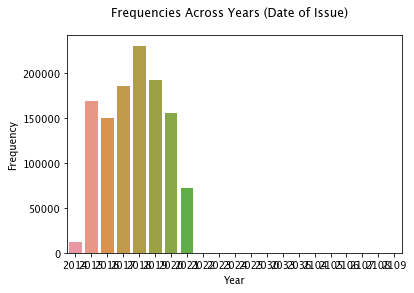

In [57]:
fig, ax = plt.subplots()
sns.barplot(
    x=df_freq_date_of_issue.groupby("Year").sum().index,
    y=df_freq_date_of_issue.groupby("Year").sum()["Frequency"],
    ax=ax
); # not creating new
   # var for the sum()
   # DataFrame b/c
   # not too computation
   # -ally expensive
   # with this data size
   # (less lines - better
   # readability)
fig.suptitle("Frequencies Across Years (Date of Issue)");

In [58]:
df_freq_date_of_issue.groupby("Year").sum()["Frequency"]

Year
2014     12413
2015    168981
2016    149300
2017    185383
2018    229928
2019    191757
2020    155115
2021     71496
2022         3
2023         2
2024         2
2025         1
2030         2
2033         1
2036         1
2104         1
2105         7
2106         3
2107         1
2108         1
2109         1
Name: Frequency, dtype: int64

Based on the distributions, there are less than half of the months in the year worth of data in 2014 (when the data started getting collected) until now (2021 and future years?! - typos or "bad" data within the data set). I am now removing those years from the sample data that we are analyzing.

In [59]:
df = df[(df["Date of Issue"].dt.year > 2014) & (df["Date of Issue"].dt.year < 2021)]
df_freq_date_of_issue = _gen_freq_months(df) # regenerate the frequencies based on
                                             # updated sample data

Verify that we have successfully filtered out those years:

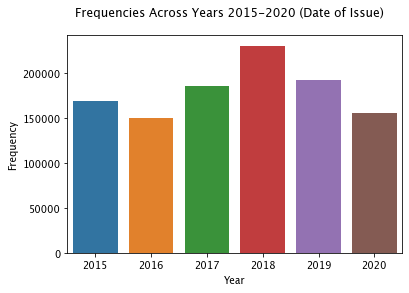

In [60]:
fig, ax = plt.subplots()
sns.barplot(
    x=df_freq_date_of_issue.groupby("Year").sum().index,
    y=df_freq_date_of_issue.groupby("Year").sum()["Frequency"],
    ax=ax
)
fig.suptitle("Frequencies Across Years 2015-2020 (Date of Issue)");

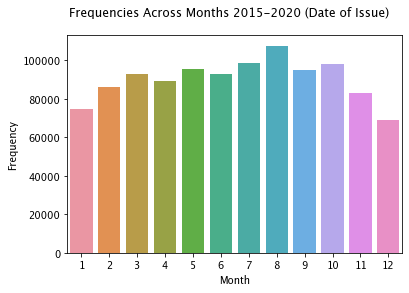

In [61]:
fig, ax = plt.subplots()
sns.barplot(
    x=df_freq_date_of_issue.groupby("Month").sum().index,
    y=df_freq_date_of_issue.groupby("Month").sum()["Frequency"],
    ax=ax
); # not creating new
   # var for the sum()
   # DataFrame b/c
   # not too computation
   # -ally expensive
   # with this data size
   # (less lines - better
   # readability)
fig.suptitle("Frequencies Across Months 2015-2020 (Date of Issue)");

Let's see the distribution of calls across all individual months.

In [62]:
df_freq_date_of_issue.describe()

,Frequency
count,72.000000
mean,15006.444444
std,3571.412566
min,5936.000000
25%,12842.750000
50%,14910.500000
75%,16961.500000
max,22591.000000


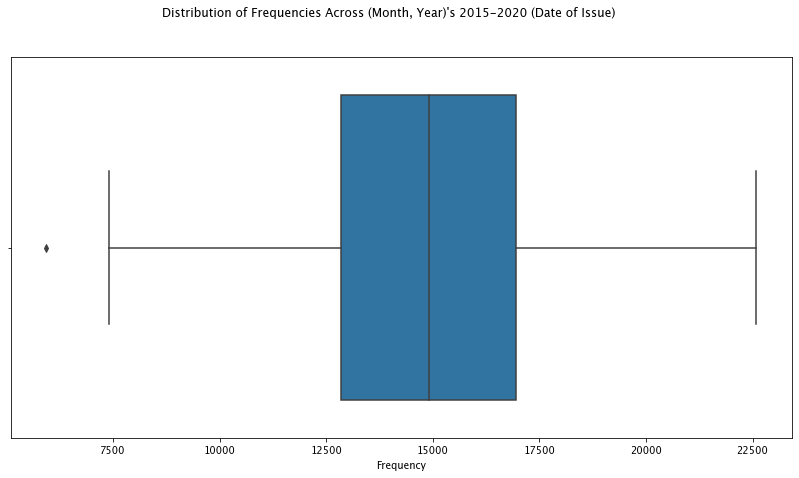

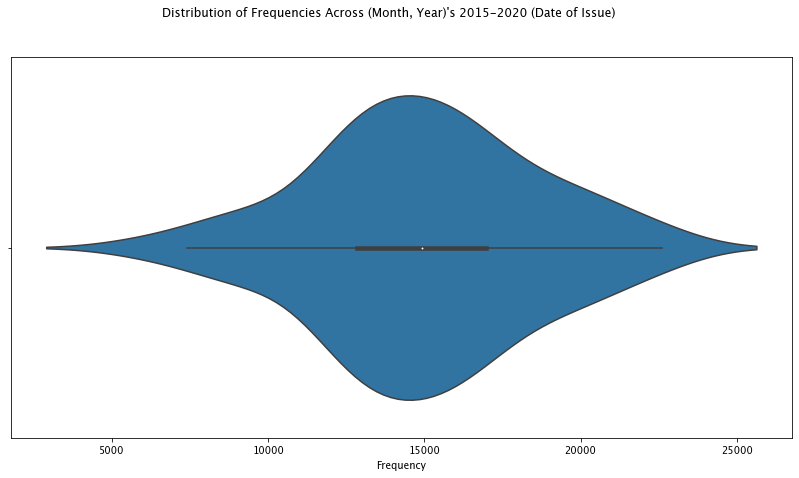

In [63]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.boxplot(
    data=df_freq_date_of_issue, 
    x="Frequency", 
    ax=ax
)
fig.suptitle(
    "Distribution of Frequencies Across " + \
    "(Month, Year)'s 2015-2020 (Date of Issue)"
)

fig, ax = plt.subplots(figsize=(14, 7))
sns.violinplot(
    data=df_freq_date_of_issue, 
    x="Frequency", ax=ax)
fig.suptitle(
    "Distribution of Frequencies Across " + \
    "(Month, Year)'s 2015-2020 (Date of Issue)"
);

We can keep the outliers for now. It looks like there were typically (median) around 122 reports per month.

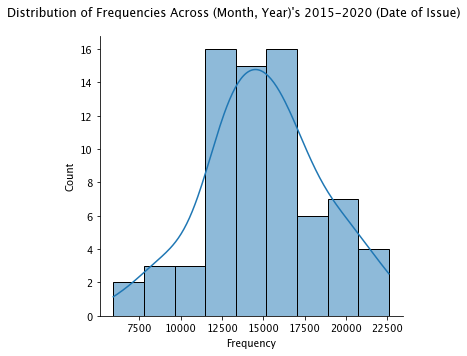

In [64]:
fg = sns.displot(kind="hist", data=df_freq_date_of_issue, x="Frequency", kde=True);
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle("Distribution of Frequencies Across (Month, Year)'s 2015-2020 (Date of Issue)");

The distribution of the frequencies month-to-month were fairly normal (again, median of 122).

<br/>**Looking at general distributional data for "Method"**

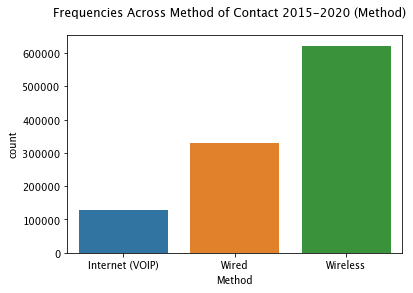

In [65]:
fig, ax = plt.subplots()
sns.countplot(
    data=df,
    x="Method",
    ax=ax
);
fig.suptitle("Frequencies Across Method of Contact 2015-2020 (Method)");

<br/>**Looking at frequency data for "Type of Call or Messge":**

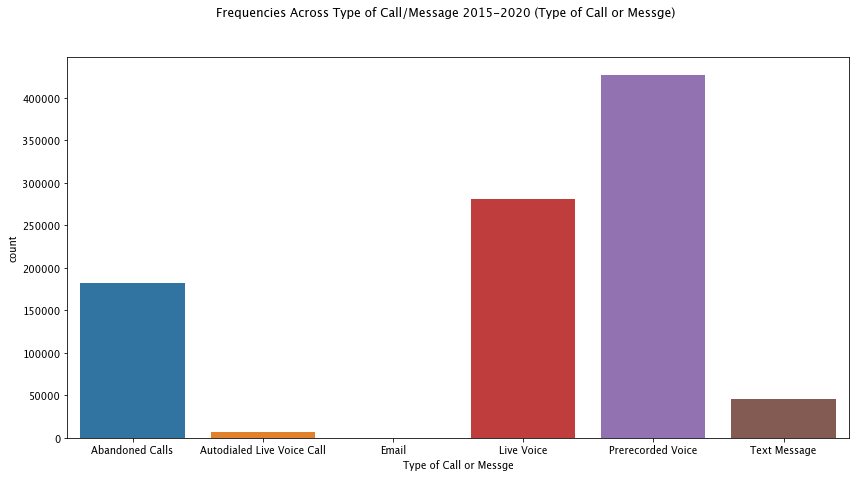

In [66]:
fig, ax = plt.subplots(figsize=(14,7))
sns.countplot(
    data=df,
    x="Type of Call or Messge",
    ax=ax
)
fig.suptitle(
    "Frequencies Across Type of Call/Message 2015-2020 (Type of Call or Messge)"
);

<br/>**Looking at frequency data for "State":**

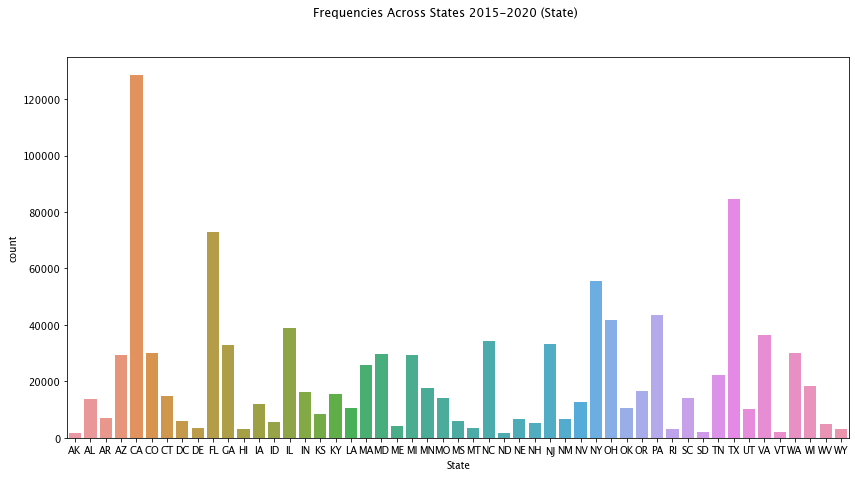

In [67]:
fig, ax = plt.subplots(figsize=(14,7))
sns.countplot(
    data=df,
    x="State",
    ax=ax
)
fig.suptitle(
    "Frequencies Across States 2015-2020 (State)"
);

Due to different states having different populations, the FCC complaint frequencies (2015-2020) across states countplot needs to be normalized by the population of each state.

Let's compile that state frequency data in one DataFrame and then find the complaint frequency by capita.

In [68]:
def _add_state_populations(df_freq_by_state: pd.DataFrame, new_col_title: str):
    search = SearchEngine(simple_zipcode=True, db_file_dir="../data/zip_data_raw")
    state_population = 0
    for state in df_freq_by_state.index:
        # 100000 b/c max. num of possible zip codes 00000-99999 
        # (it's just an upper bound)
        state_zips = search.by_state(state, returns=100000)
        for state_zip in state_zips:
            if state_zip.population is not None: # 90099, for example, has no residents
                state_population+=state_zip.population
        df_freq_by_state.loc[state, new_col_title] = state_population
        state_population = 0

In [69]:
df_freq_by_state = pd.DataFrame(
    {
        "Freq" : df["State"].value_counts(dropna=True).values,
        "Pop Size" : np.nan
    }, 
    index=pd.Index(data=df["State"].value_counts(dropna=True).index, name="State"),
    columns=["Freq", "Pop Size"]
)
# print(df_freq_by_state)
_add_state_populations(
    df_freq_by_state = df_freq_by_state,
    new_col_title = "Pop Size"
)
df_freq_by_state["Pop Size"] = df_freq_by_state.loc[:,"Pop Size"].astype(int)
display(df_freq_by_state.head())

,Freq,Pop Size
State,,
CA,128380,37070683
TX,84760,25005364
FL,72920,18762334
NY,55429,19284068
PA,43419,12562658


In [70]:
df_freq_by_state["Freq Per Capita"] = \
df_freq_by_state["Freq"] / df_freq_by_state["Pop Size"]
df_freq_by_state.sort_values(by="Freq Per Capita", ascending=False, inplace=True)
display(
    df_freq_by_state.head()
)

,Freq,Pop Size,Freq Per Capita
State,,,
DC,6042,593412,0.010182
CO,30077,4957182,0.006067
WY,3175,550410,0.005768
MD,29692,5737788,0.005175
AZ,29271,6188636,0.004730


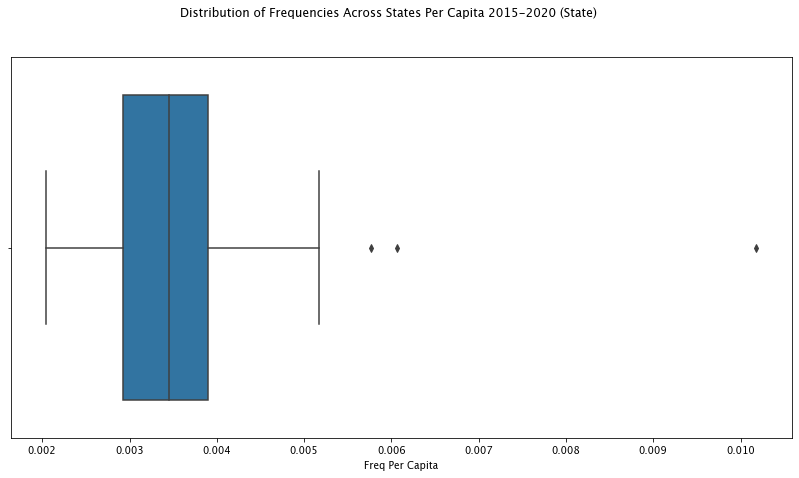

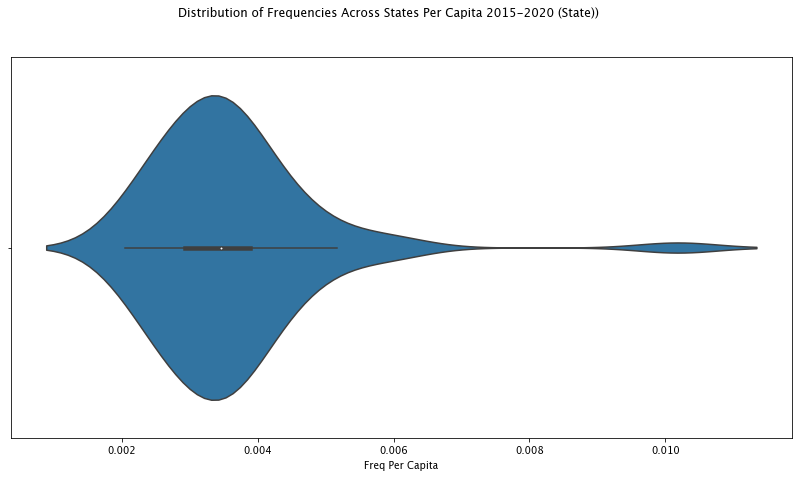

In [71]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.boxplot(data=df_freq_by_state, x="Freq Per Capita", ax=ax)
fig.suptitle("Distribution of Frequencies Across States Per Capita 2015-2020 (State)");

fig, ax = plt.subplots(figsize=(14, 7))
sns.violinplot(data=df_freq_by_state, x="Freq Per Capita", ax=ax)
fig.suptitle("Distribution of Frequencies Across States Per Capita 2015-2020 (State))");

Right skewed; besides outliers, appears fairly normally distributed near median.

In [72]:
iqr = df_freq_by_state.describe().loc["75%","Freq Per Capita"] - \
      df_freq_by_state.describe().loc["25%","Freq Per Capita"]
lower_outlier_threshold = df_freq_by_state.describe().loc["25%","Freq Per Capita"] - (1.5*iqr)
upper_outlier_threshold = df_freq_by_state.describe().loc["75%","Freq Per Capita"] + (1.5*iqr)
df_freq_by_state[
    (df_freq_by_state["Freq Per Capita"] < lower_outlier_threshold) |
    (df_freq_by_state["Freq Per Capita"] > upper_outlier_threshold)
]

,Freq,Pop Size,Freq Per Capita
State,,,
DC,6042,593412,0.010182
CO,30077,4957182,0.006067
WY,3175,550410,0.005768


Washington DC, Colorado, and Wyoming had the largest frequencies per capita, respectively. Those states' frequencies per capita in the data analyzed (frequencies by state).

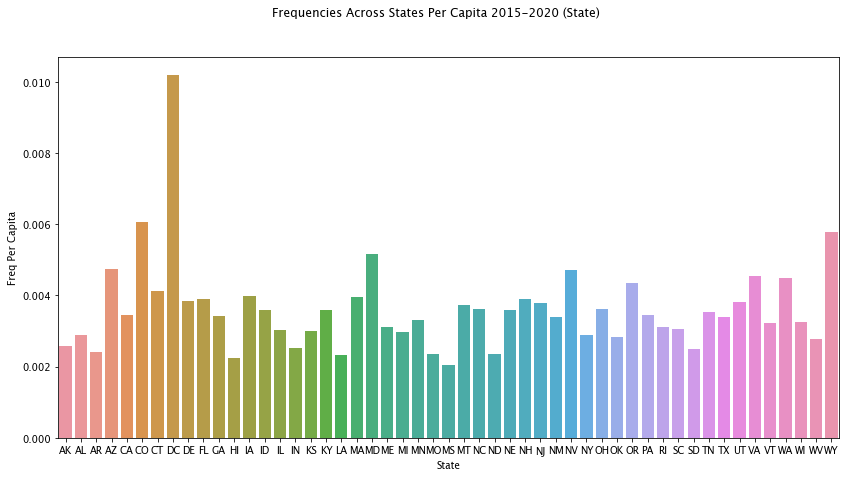

In [73]:
fig, ax = plt.subplots(figsize=(14,7))
sns.barplot(
    data=df_freq_by_state,
    x=df_freq_by_state.index,
    y="Freq Per Capita",
    ax=ax
)
fig.suptitle(
    "Frequencies Across States Per Capita 2015-2020 (State)"
);

How about ordered (most to least)?

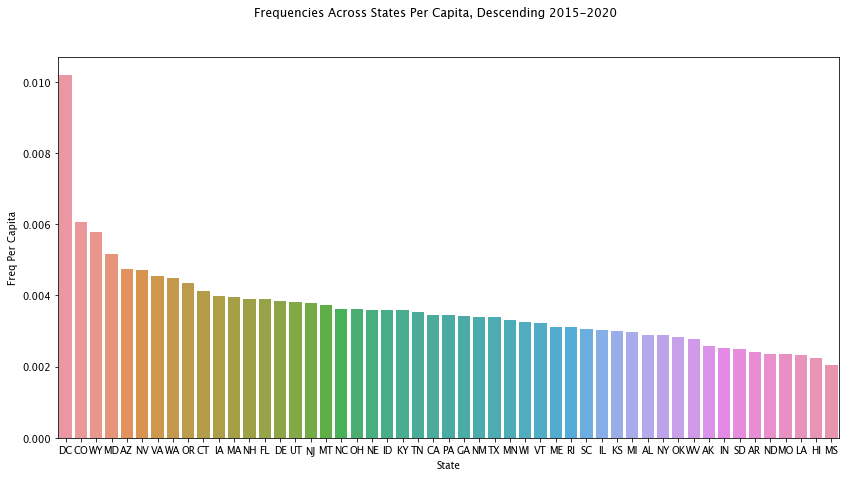

In [74]:
fig, ax = plt.subplots(figsize=(14,7))
sns.barplot(
    data=df_freq_by_state,
    x=df_freq_by_state.index,
    y="Freq Per Capita",
    order=df_freq_by_state.index,
    ax=ax
)
fig.suptitle(
    "Frequencies Across States Per Capita, Descending 2015-2020"
);

### Step 3: Pre-ML Models (Clustering)

In [75]:
df_lng_lat = pd.DataFrame(
    {
        "lat" : df[df["Zip Info"].notnull()]["Zip Info"].apply(
            lambda sz: sz.lat
        ), # sz stands for SimpleZipcode object
        "lng" : df[df["Zip Info"].notnull()]["Zip Info"].apply(
            lambda sz: sz.lng
        ) # sz stands for SimpleZipcode object
    },
    index=df[df["Zip Info"].notnull()].index
)

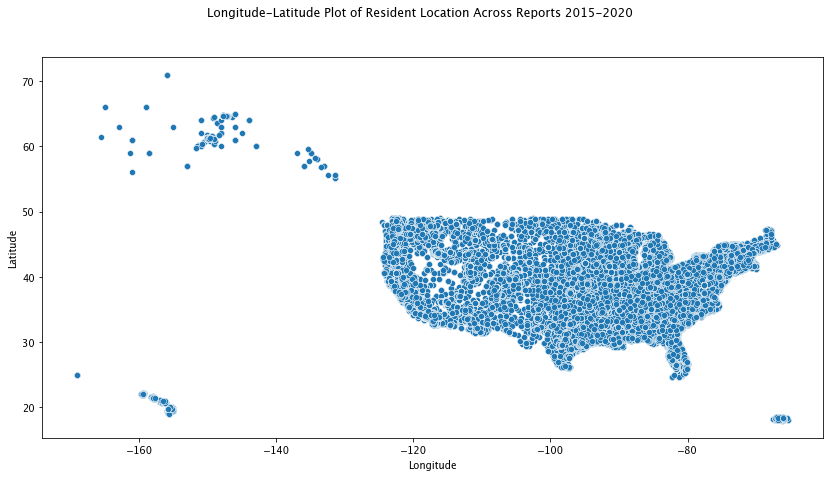

In [76]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.scatterplot(data=df_lng_lat, x="lng", y="lat", ax=ax);
fig.suptitle("Longitude-Latitude Plot of Resident Location Across Reports 2015-2020")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude");

Now, let us try to map this onto some set of Cartesian coordinates. This is going to be a *relativistic* Cartesian coordinate plot; there is not necessarily an objective, standard Cartesian coordinate plot that is commonly used.

In [77]:
def _calculate_dlng(lng_center: float, lat_center: float, lng_pt: float, lat_pt: float):
    return (lng_pt-lng_center)*40000*math.cos((lat_center+lat_pt)*math.pi/360)/360

def _calculate_dlat(lat_center: float, lat_pt: float):
    return (lat_pt-lat_center)*40000/360

Formulas are attributed to the user Floris on Stack Overflow.<sup>9</sup>

In [78]:
# geographic center of the US latitude and longitude
# (decimal rather than DMS, i.e. degrees, minutes, seconds) values
lng_center = -103.771556
lat_center = 44.967243
df_lng_lat["dlng"] = df_lng_lat.apply(
    func=lambda row: _calculate_dlng(
        lng_center=lng_center, 
        lat_center=lat_center, 
        lng_pt=row["lng"],
        lat_pt=row["lat"]
    ),
    axis=1
)
df_lng_lat["dlat"] = df_lng_lat.apply(
    func=lambda row: _calculate_dlat(
        lat_center=lat_center,
        lat_pt=row["lat"]
    ),
    axis=1
)

In [79]:
df_lng_lat["lng_cart"] = df_lng_lat.apply(
    func=lambda row: row["lng"] + row["dlng"],
    axis=1
)
df_lng_lat["lat_cart"] = df_lng_lat.apply(
    func=lambda row: row["lat"] + row["dlat"],
    axis=1
)

Geographic center of the United States obtained from Wikipedia and converted to decimal in the "GeoHack" app, which will serve as the center of the map.<sup>10 11</sup>

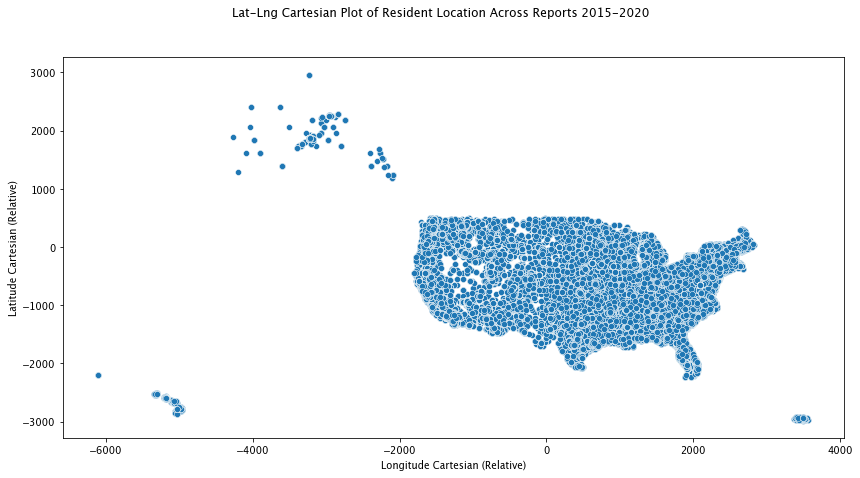

In [80]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.scatterplot(data=df_lng_lat, x="lng_cart", y="lat_cart", ax=ax);
fig.suptitle("Lat-Lng Cartesian Plot of Resident Location Across Reports 2015-2020")
ax.set_xlabel("Longitude Cartesian (Relative)")
ax.set_ylabel("Latitude Cartesian (Relative)");

Did it make that much of a difference to map the longitude-latitude values to a Cartesian coordinate system? No. But, at least we tried (in case we did).

Key takeaway: Call reporting is quite spread out across the country, as expected. 

Let's see the geo-density of the reported calls. And, we might as well use the real, widely-adopted longitude-latitude values, as it did not appear to make much of a difference visually.

In [81]:
# sns.kdeplot(data=df_lng_lat, x="lng", y="lat", fill=True)

### Step 4: Predicting time-series data (number of complaints) using ANN with multiple hidden layers

Through the EDA, it was discovered that there was *some*, even if not much, periodicity within the frequencies across the months and years. Let's see if we can use a basic multi-hidden-layered ANN modeled sequentially and with Dense layers for the hidden layers.<sup>12</sup>

In [82]:
df_freq_day_of_issue = pd.DataFrame(
    {
        "Day of Issue": df["Date of Issue"],
        "Freq": np.nan
    }
)
display(df_freq_day_of_issue)

,Day of Issue,Freq
0,2020-09-18,NaN
1,2020-09-18,NaN
2,2020-09-14,NaN
3,2020-09-16,NaN
4,2020-09-21,NaN
...,...,...
1173859,2020-03-09,NaN
1173866,2020-09-02,NaN
1173883,2020-09-02,NaN
1173899,2020-09-02,NaN


In [83]:
df_freq_day_of_issue = \
df_freq_day_of_issue \
.sort_values("Day of Issue") \
.groupby(by="Day of Issue") \
.size()
df_freq_day_of_issue = pd.DataFrame(
    {
        "Day of Issue": df_freq_day_of_issue.index,
        "Freq": df_freq_day_of_issue.values
    }
)
display(df_freq_day_of_issue)

,Day of Issue,Freq
0,2015-01-01,369
1,2015-01-02,390
2,2015-01-03,233
3,2015-01-04,87
4,2015-01-05,596
...,...,...
2187,2020-12-27,82
2188,2020-12-28,315
2189,2020-12-29,383
2190,2020-12-30,309


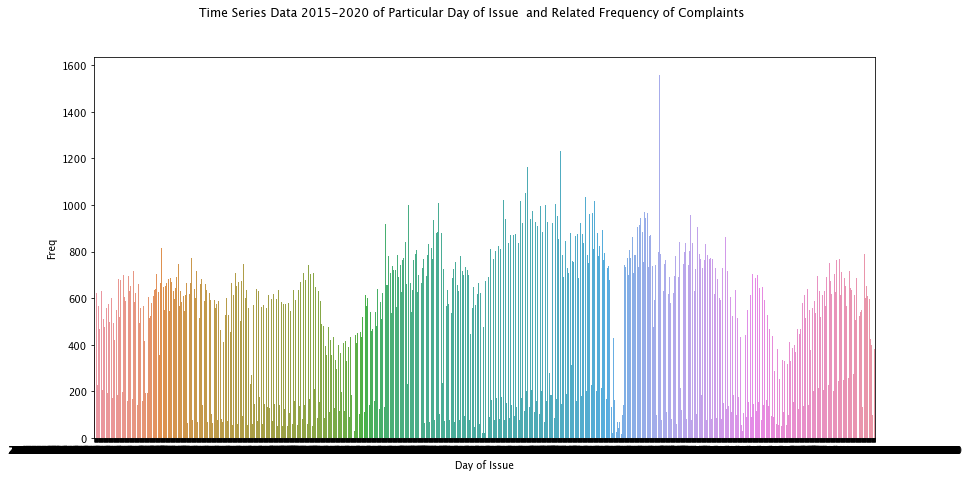

In [84]:
fig, ax = plt.subplots(figsize=(14,7))
ax = sns.barplot(data=df_freq_day_of_issue, x="Day of Issue", y="Freq")
fig.suptitle("Time Series Data 2015-2020 of Particular Day of Issue " + \
             " and Related Frequency of Complaints");

Many periodic function can be converted into a linear combination of sines and cosines. The periodicity over each month and over each year will be captured through their respective linear combinations of sines and cosines.<sup>13</sup>

The constants below represent the number of seconds within the time delta represented by the variable (day, month, year, etc.). This will be used to normalize the time stamp, which will be intially converted into seconds from January 1, 1970, using scaled sin and consine functions. I have written the function for the conversion *based upon* the function outlines and constants provided by Tensor Flow, after understanding them, of course.<sup>12</sup> (I wanted to ensure that the proof of concept behind mapping time series, that is, in seconds, to sin/cos values, after which they are fed into a neural net to be trained at predicting a target numeric variable, was somewhat tried and testing.) I did, though, create the analogous sin and cos functions for months, creating my own method for normalizing the period within each month (slight obstacle due to non-uniform number of days in a month).

In [85]:
day_num_sec = 24*60*60
year_num_sec = (365.2425)*day_num_sec

In [86]:
def _compute_month_sin(ts: pd.Timestamp):
    num_sec = (ts - pd.Timestamp("1/1/1970")).total_seconds()
    month_num_sec = day_num_sec * pd.Period(ts, freq='D').days_in_month
    return np.sin(num_sec * (2 * np.pi / month_num_sec))

def _compute_month_cos(ts: pd.Timestamp):
    num_sec = (ts - pd.Timestamp("1/1/1970")).total_seconds()
    month_num_sec = day_num_sec * pd.Period(ts, freq='D').days_in_month
    return np.cos(num_sec * (2 * np.pi / month_num_sec))

def _compute_year_sin(ts: pd.Timestamp):
    num_sec = (ts - pd.Timestamp("1/1/1970")).total_seconds()
    return np.sin(num_sec * (2 * np.pi / year_num_sec))

def _compute_year_cos(ts: pd.Timestamp):
    num_sec = (ts - pd.Timestamp("1/1/1970")).total_seconds()
    return np.cos(num_sec * (2 * np.pi / year_num_sec))

Yes, Unix epoch time technically does not match up with UTC because it does not account for leap seconds. We will not be worrying about this because there have only been 37 leap seconds thus far.<sup>14</sup>

Also, I could refactor the code above, but it's too few lines to warrant it; doing so would probably just reduce readability, quite frankly.

In [87]:
def _apply_and_get_trig_func_by_col(df: pd.DataFrame, trig_func):
    return df.apply(
        lambda row: trig_func(row["Day of Issue"]),
        axis=1
    )

In [88]:
df_freq_day_of_issue['Month sin'] = _apply_and_get_trig_func_by_col(df=df_freq_day_of_issue, trig_func=_compute_month_sin)
df_freq_day_of_issue['Month cos'] = _apply_and_get_trig_func_by_col(df=df_freq_day_of_issue, trig_func=_compute_month_cos)
df_freq_day_of_issue['Year sin'] = _apply_and_get_trig_func_by_col(df=df_freq_day_of_issue, trig_func=_compute_year_sin)
df_freq_day_of_issue['Year cos'] = _apply_and_get_trig_func_by_col(df=df_freq_day_of_issue, trig_func=_compute_year_cos)

In [89]:
df_freq_day_of_issue

,Day of Issue,Freq,Month sin,Month cos,Year sin,Year cos
0,2015-01-01,369,0.937752,0.347305,0.001505,0.999999
1,2015-01-02,390,0.988468,0.151428,0.018707,0.999825
2,2015-01-03,233,0.998717,-0.050649,0.035903,0.999355
3,2015-01-04,87,0.968077,-0.250653,0.053089,0.998590
4,2015-01-05,596,0.897805,-0.440394,0.070258,0.997529
...,...,...,...,...,...,...
2187,2020-12-27,82,-0.998717,-0.050649,-0.075062,0.997179
2188,2020-12-28,315,-0.988468,0.151428,-0.057898,0.998323
2189,2020-12-29,383,-0.937752,0.347305,-0.040716,0.999171
2190,2020-12-30,309,-0.848644,0.528964,-0.023523,0.999723


In [90]:
X = df_freq_day_of_issue[["Month sin", "Month cos", "Year sin", "Year cos"]]
y = df_freq_day_of_issue["Freq"]

BREAKPOINT FOR SELF

In [91]:
# clf = KerasRegressor(
#       model=create_keras_model, 
#       verbose=1, 
#       epochs=10, 
#       batch_size=4,
#       optimizer='adam', # compile param
#       loss='mean_squared_error', # compile param
#       metrics=["mean_squared_error", "accuracy"], # compile param
#       num_hidden=100, # model param
#       activation='relu' # model param
# )     

BREAKPOINT FOR SELF

In [92]:
# from tensorflow.python.ops.math_ops import reduce_prod

In [93]:
# mpl params
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

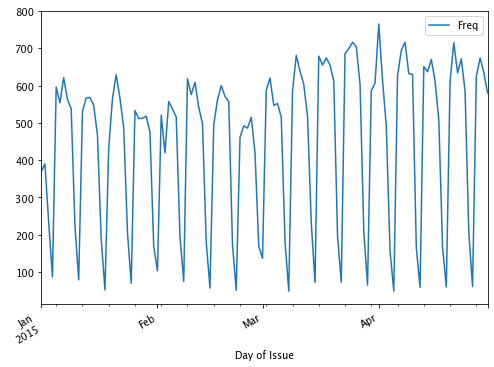

In [94]:
plot_features = df_freq_day_of_issue[['Freq']][:120]
plot_features.index = \
df_freq_day_of_issue["Day of Issue"][:120]
_ = plot_features.plot(subplots=True)

In [95]:
pct_train = 0.8
pct_val = 0.1
pct_test = 0.1 # implied; just here to be explicit

In [96]:
column_indices = {name: i for i, name in enumerate(pd.DataFrame(df_freq_day_of_issue["Freq"]).columns)}

num_pts = len(df_freq_day_of_issue)
train_df = pd.DataFrame(
    df_freq_day_of_issue["Freq"]
)[0:int(pct_train*num_pts)]
val_df = pd.DataFrame(
    df_freq_day_of_issue["Freq"]
)[int(pct_train*num_pts):int((pct_train+pct_test)*num_pts)]
test_df = pd.DataFrame(
    df_freq_day_of_issue["Freq"]
)[int((pct_train+pct_test)*num_pts):]

num_features = 1

In [97]:
train_df

,Freq
0,369
1,390
2,233
3,87
4,596
...,...
1748,724
1749,683
1750,657
1751,567


In [98]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [99]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [100]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [101]:
def plot(self, model=None, plot_col='Freq', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

In [102]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=12
  )

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [103]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [104]:
window = WindowGenerator(
    input_width=28, label_width=28, shift=1,
    label_columns=['Freq'])

window

Total window size: 29
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
Label column name(s): ['Freq']

In [105]:
model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(8, return_sequences=True),
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.LSTM(2, return_sequences=True),

    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [106]:
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

history = model.fit(
    window.train, 
    epochs=100,
    validation_data=window.val
)

Epoch 1/100
144/144 [==============================] - 19s 79ms/step - loss: 0.9825 - mean_absolute_error: 0.8601 - val_loss: 0.5127 - val_mean_absolute_error: 0.5894
Epoch 2/100
144/144 [==============================] - 7s 47ms/step - loss: 0.8433 - mean_absolute_error: 0.7909 - val_loss: 0.3463 - val_mean_absolute_error: 0.4694
Epoch 3/100
144/144 [==============================] - 7s 47ms/step - loss: 0.5714 - mean_absolute_error: 0.6172 - val_loss: 0.3661 - val_mean_absolute_error: 0.4636
Epoch 4/100
144/144 [==============================] - 7s 47ms/step - loss: 0.4578 - mean_absolute_error: 0.5256 - val_loss: 0.3383 - val_mean_absolute_error: 0.4236
Epoch 5/100
144/144 [==============================] - 7s 50ms/step - loss: 0.3791 - mean_absolute_error: 0.4549 - val_loss: 0.3309 - val_mean_absolute_error: 0.4171
Epoch 6/100
144/144 [==============================] - 7s 49ms/step - loss: 0.3293 - mean_absolute_error: 0.4067 - val_loss: 0.2917 - val_mean_absolute_error: 0.3884
Epo

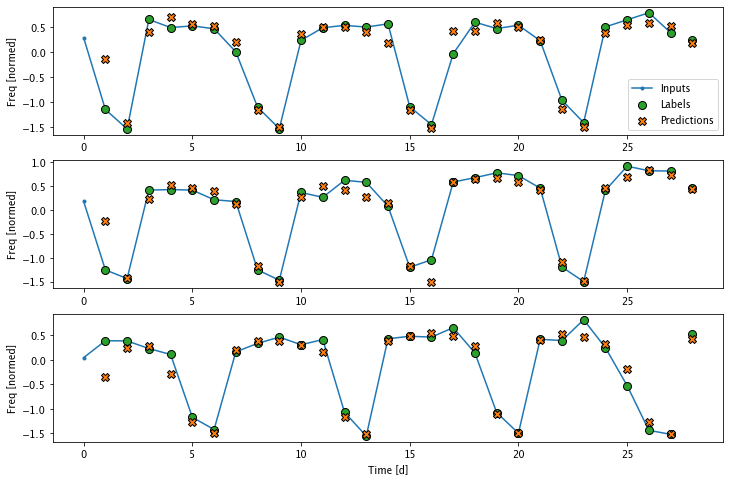

In [107]:
window.plot(model)

In [108]:
IPython.display.clear_output()
val_performance['LSTM'] = model.evaluate(val_df)
performance['LSTM'] = model.evaluate(test_df, verbose=0)

NameError: name 'IPython' is not defined

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_lng_lat["lng_cart", "lat_cart"])
kmeans.n_iter_
kmeans_pred = kmeans.predict(df_lng_lat["lng_cart", "lat_cart"])
plt.scatter(data=df_lng_lat, x="lng_cart", y="lat_cart", c=kmeans_pred)

### References
1. Data from https://data.world/kgarrett/unwanted-calls
2. Verified description of the variable using https://opendata.fcc.gov/Consumer/Consumer-Complaints-Data-Unwanted-Calls/vakf-fz8e
3. Python wrapper of Google's ```phonenumbers``` library (documentation): https://pypi.org/project/phonenumbers/
4. FCC unwanted call complaint form: https://consumercomplaints.fcc.gov/hc/en-us/requests/new?ticket_form_id=39744
5. ```uszipcode``` documentation: https://pypi.org/project/uszipcode/
6. ```us``` documentation: https://pypi.org/project/us/
7. Stack Overflow: https://stackoverflow.com/questions/27365467/can-pandas-plot-a-histogram-of-dates
8. FCC https://consumercomplaints.fcc.gov/hc/en-us
9. Stack Overflow: https://stackoverflow.com/questions/24617013/convert-latitude-and-longitude-to-x-and-y-grid-system-using-python
10. Wikipedia article on Geographic Center of US: https://en.wikipedia.org/wiki/Geographic_center_of_the_United_States#:~:text=The%20geographic%20center%20of%20the,%C2%B046%E2%80%B217.60283%E2%80%B3W.
11. GeoHack tool: https://geohack.toolforge.org/geohack.php?pagename=Geographic_center_of_the_United_States&params=44_58_2.07622_N_103_46_17.60283_W_
12. Inspired by TensorFlow's guide on time series forecasting with ANN using TensorFlow's Python package: https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_dense
13. MIT (Massachusetts Institute of Technology) Document "The Sinusoidal Identity": https://ocw.mit.edu/courses/mathematics/18-03sc-differential-equations-fall-2011/unit-i-first-order-differential-equations/sinusoidal-functions/MIT18_03SCF11_s7_3text.pdf
14. Wikipedia article on Leap Second: https://en.wikipedia.org/wiki/Leap_second